<a href="https://colab.research.google.com/github/davidguzmanr/Aprendizaje-Profundo/blob/main/Tareas/Tarea-2/Tarea_2_ejercicio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: redes convolucionales

- **E. David Guzmán Ramírez**
- **Introducción al Aprendizaje Profundo 2021-II**
- **Licenciatura en Ciencia de Datos CU UNAM**

In [ ]:
! pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import io
from skimage.transform import resize
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torchvision.datasets.utils as tvutils
from torchinfo import summary

import os
import random
from collections import Counter
from itertools import islice as take
from tqdm import trange, tqdm

sns.set_style('darkgrid')

## Ejercicio 2

Extiende la libreta [2b_comida_inception.ipynb](https://github.com/bereml/iap/blob/master/libretas/2b_comida_inception.ipynb) para implementar y entrenar la arquitectura tipo ResNet que se especifica en la figura 1.

<img src="https://raw.githubusercontent.com/davidguzmanr/Aprendizaje-Profundo/main/Tareas/Images/tarea2-2.png" />

### Auxiliares

In [ ]:
# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            ax[r, c].axis('off')
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=42):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

### Descarga de datos

In [ ]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download'
base_dir = 'data/recipes'
filename = 'recipes2k.tar.gz'
data_dir = 'data/recipes/recipes2k'
filepath = os.path.join(base_dir, filename)

In [ ]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

El fichero “data/recipes/recipes2k.tar.gz” ya está ahí, no se recupera.


### Cargador de datos y exploración

In [ ]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


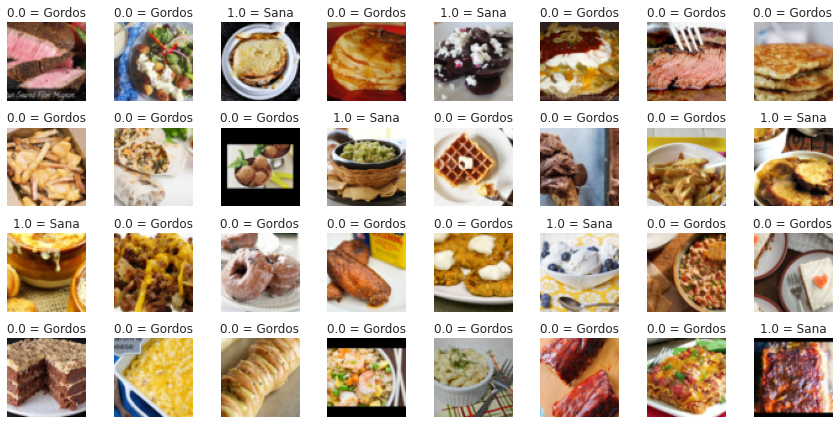

In [ ]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

trn_ds = RecipesDS(data_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_batch(x, titles, ROWS, COLS)

### Arquitectura

<img src="https://raw.githubusercontent.com/davidguzmanr/Aprendizaje-Profundo/main/Tareas/Images/tarea2-2.png" />

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self):
        # Inicilización del objeto padre
        super(ResNetBlock, self).__init__()
        
        # Primera convolución
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.ReLU()
        )
        
        # Segunda convolución
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        
        return self.conv1(x) + self.conv2(x)

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.resnet = nn.Sequential(
            # [M, 3, 64, 64] -> [M, 3, 64, 64]
            ResNetBlock(),
            # [M, 3, 64, 64] -> [M, 3, 32, 32]
            nn.MaxPool2d(kernel_size=2),       
            # [M, 3, 32, 32] -> [M, 3, 32, 32]
            ResNetBlock(),
            # [M, 3, 32, 32] -> [M, 3, 16, 16]
            nn.MaxPool2d(kernel_size=2),  
        )
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(in_features=3*16*16, out_features=1)
        
    def forward(self, x):
        
        x = self.resnet(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

In [ ]:
# Definimos nuestro modelo y probamos con unos datos sintéticos
model = ResNet()
x = torch.zeros(1,3,64,64)
model(x).shape

torch.Size([1, 1])

In [ ]:
# Lo movemos a la GPU, en caso de que haya
model.to(device)

ResNet(
  (resnet): Sequential(
    (0): ResNetBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResNetBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
summary(model, (1, 3, 64, 64), device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 3, 16, 16]            --
|    └─ResNetBlock: 2-1                  [1, 3, 64, 64]            --
|    |    └─Sequential: 3-1              [1, 3, 64, 64]            180
|    |    └─Conv2d: 3-2                  [1, 3, 64, 64]            12
|    └─MaxPool2d: 2-2                    [1, 3, 32, 32]            --
|    └─ResNetBlock: 2-3                  [1, 3, 32, 32]            --
|    |    └─Sequential: 3-3              [1, 3, 32, 32]            180
|    |    └─Conv2d: 3-4                  [1, 3, 32, 32]            12
|    └─MaxPool2d: 2-4                    [1, 3, 16, 16]            --
├─Flatten: 1-2                           [1, 768]                  --
├─Linear: 1-3                            [1, 1]                    769
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
Total mult-adds (M): 0.88
Input size (MB): 0.05
Forward/backward pass size (MB): 0.6

### Entrenamiento

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        # Los pasamos a la GPU, en caso de que haya
        x, y_true = x.to(device), y_true.to(device)
        
        # computamos logits
        y_lgts = model(x)
                
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            # Los pasamos a la GPU, en caso de que haya
            x, y_true = x.to(device), y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            
            # computamos las clases
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=1e-1, epochs=15, trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist

In [ ]:
loss_hist, acc_hist = train(model, trn_dl, epochs=20, lr=1e-3)

  5%|▌         | 1/20 [00:07<02:26,  7.73s/it]

E00 loss= 47.38 acc=79.04


 10%|█         | 2/20 [00:15<02:19,  7.73s/it]

E01 loss= 47.73 acc=79.95


 15%|█▌        | 3/20 [00:23<02:10,  7.68s/it]

E02 loss= 44.20 acc=80.93


 20%|██        | 4/20 [00:30<02:03,  7.69s/it]

E03 loss= 43.06 acc=81.02


 25%|██▌       | 5/20 [00:38<01:55,  7.68s/it]

E04 loss= 41.46 acc=81.77


 30%|███       | 6/20 [00:45<01:46,  7.60s/it]

E05 loss= 40.69 acc=83.07


 35%|███▌      | 7/20 [00:53<01:37,  7.48s/it]

E06 loss= 39.61 acc=82.54


 40%|████      | 8/20 [01:00<01:28,  7.40s/it]

E07 loss= 40.60 acc=82.42


 45%|████▌     | 9/20 [01:07<01:20,  7.33s/it]

E08 loss= 38.44 acc=84.23


 50%|█████     | 10/20 [01:14<01:13,  7.30s/it]

E09 loss= 38.32 acc=84.38


 55%|█████▌    | 11/20 [01:22<01:05,  7.28s/it]

E10 loss= 36.94 acc=85.32


 60%|██████    | 12/20 [01:29<00:58,  7.26s/it]

E11 loss= 35.46 acc=84.74


 65%|██████▌   | 13/20 [01:36<00:50,  7.24s/it]

E12 loss= 35.25 acc=85.44


 70%|███████   | 14/20 [01:43<00:43,  7.23s/it]

E13 loss= 34.71 acc=84.64


 75%|███████▌  | 15/20 [01:50<00:36,  7.22s/it]

E14 loss= 34.28 acc=84.82


 80%|████████  | 16/20 [01:58<00:28,  7.21s/it]

E15 loss= 32.77 acc=86.08


 85%|████████▌ | 17/20 [02:05<00:22,  7.34s/it]

E16 loss= 32.76 acc=87.25


 90%|█████████ | 18/20 [02:13<00:14,  7.43s/it]

E17 loss= 31.68 acc=86.38


 95%|█████████▌| 19/20 [02:21<00:07,  7.52s/it]

E18 loss= 31.25 acc=88.15


100%|██████████| 20/20 [02:28<00:00,  7.43s/it]

E19 loss= 30.35 acc=87.83


### Gráficas de pérdida y accuracy

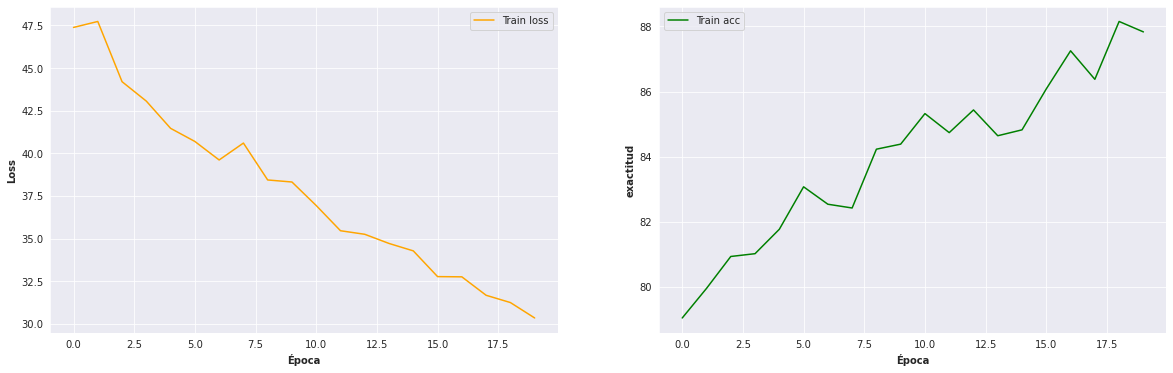

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax0.plot(loss_hist, 'orange', label='Train loss')
ax0.set_xlabel('Época', weight='bold')
ax0.set_ylabel('Loss', weight='bold')
ax0.legend()

ax1.plot(acc_hist, 'green', label='Train acc')
ax1.set_xlabel('Época', weight='bold')
ax1.set_ylabel('exactitud', weight='bold')
ax1.legend()

plt.show()

### Probando con vitamina T 

In [ ]:
# cargamos imágenes de prueba
imgs = []
tst_dir = os.path.join(data_dir, 'tst')
names = sorted(os.listdir(tst_dir))
for name in names:
    path = os.path.join(tst_dir, name)
    img = io.imread(path)
    size = min(*img.shape[:2])
    img = crop_center(img, size, size)
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    imgs.append(img)

In [ ]:
# Evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
trn_loss, trn_acc

(30.31860375993474, 87.93934992579526)

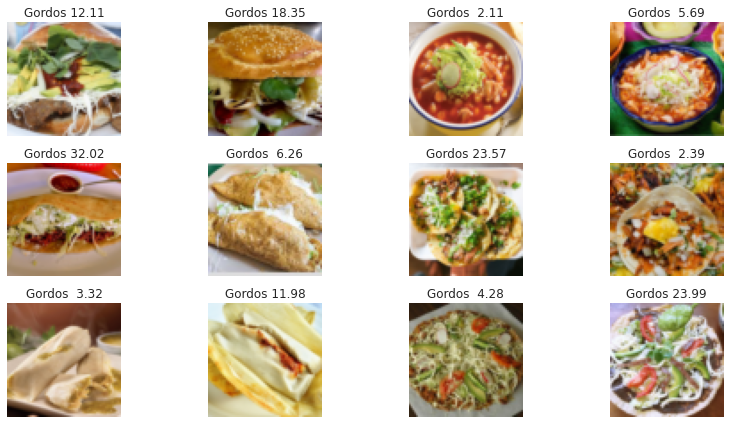

In [ ]:
# desplegamos con probas
titles = []
with torch.no_grad():
    for img in imgs:
        img_torch = numpy_to_torch(img)
        img_torch = img_torch.unsqueeze(0)
        prob = torch.sigmoid(model(img_torch.to(device)))
        prob = prob.item() * 100
        if prob < 50:
            titles.append(f'Gordos {prob:5.2f}')
        else:
            titles.append(f'Sana {prob:5.2f}')

display_grid(imgs, titles, 3, 4)

### Discusión

Con un accuracy de 87.93 en el conjunto de entrenamiento parece estar haciendo un buen trabajo, además, parece estar clasificando bien la vitamina T como poco sana. Desafortunadamente no hay un conjunto de prueba, por lo que no podemos decir si se está sobreajustando o no.